# Knowledge Graph Construction Using AI
This notebook demonstrates the construction of a knowledge graph using AI techniques. We will use two different AI models to construct the knowledge graph and compare their performance.


In [38]:
import os

data_dir = '/kaggle/input/json-data/reduced_mixed_3'

all_files = os.listdir(data_dir)
print(f"All files: {all_files}")


All files: ['sdgIndicatorData__9.3.1.json5', 'sdgIndicatorData__16.6.2.json5', 'sdgIndicatorPivotData__13.1.2.json5', 'sdgIndicatorPivotData__13.1.3.json5', 'sdgIndicatorPivotData__2.2.1.json5', 'sdgIndicatorPivotData__2.5.2.json5', 'sdgIndicatorData__11.3.1.json5', 'sdgIndicatorPivotData__3.d.2.json5', 'sdgIndicatorPivotData__12.b.1.json5', 'sdgIndicatorPivotData__17.18.2.json5', 'sdgIndicatorPivotData__8.10.2.json5', 'sdgIndicatorPivotData__16.10.1.json5', 'sdgIndicatorData__4.4.1.json5', 'sdgIndicatorData__13.2.2.json5', 'sdgIndicatorData__16.10.1.json5', 'sdgIndicatorData__7.2.1.json5', 'sdgIndicatorPivotData__10.7.2.json5', 'sdgIndicatorPivotData__8.7.1.json5', 'sdgIndicatorData__14.5.1.json5', 'sdgIndicatorData__15.1.1.json5', 'sdgIndicatorPivotData__5.6.1.json5', 'sdgIndicatorPivotData__2.2.2.json5', 'sdgIndicatorData__14.3.1.json5', 'sdgIndicatorData__3.3.5.json5', 'sdgIndicatorPivotData__2.b.1.json5', 'sdgIndicatorPivotData__17.13.1.json5', 'sdgIndicatorData__12.3.1.json5', 's

# Data Loading and Preprocessing:
* Loads SDG indicator data from multiple JSON5 files.
* Inspects and verifies data structure.

In [39]:
import json5

# Verify the content and structure of the files
data_entries = []
file_count = 0

for file_name in all_files:
    if file_name.startswith('sdgIndicatorData__') and file_name.endswith('.json5'):
        file_path = os.path.join(data_dir, file_name)
        file_count += 1
        with open(file_path, 'r') as f:
            try:
                data = json5.load(f)
                print(f"Loaded data from {file_name}: {data.keys()}")  # Print the keys to verify structure
                if 'data' in data:
                    data_entries.extend(data['data'])
            except Exception as e:
                print(f"Error loading {file_path}: {e}")

print(f"Total files processed: {file_count}")
print(f"Total data entries loaded: {len(data_entries)}")
if len(data_entries) > 0:
    print(json5.dumps(data_entries[0], indent=2))
else:
    print("No data entries loaded.")


Loaded data from sdgIndicatorData__9.3.1.json5: dict_keys(['size', 'totalElements', 'totalPages', 'pageNumber', 'data'])
Loaded data from sdgIndicatorData__16.6.2.json5: dict_keys(['size', 'totalElements', 'totalPages', 'pageNumber', 'data'])
Loaded data from sdgIndicatorData__11.3.1.json5: dict_keys(['size', 'totalElements', 'totalPages', 'pageNumber', 'data'])
Loaded data from sdgIndicatorData__4.4.1.json5: dict_keys(['size', 'totalElements', 'totalPages', 'pageNumber', 'data'])
Loaded data from sdgIndicatorData__13.2.2.json5: dict_keys(['size', 'totalElements', 'totalPages', 'pageNumber', 'data'])
Loaded data from sdgIndicatorData__16.10.1.json5: dict_keys(['size', 'totalElements', 'totalPages', 'pageNumber', 'data'])
Loaded data from sdgIndicatorData__7.2.1.json5: dict_keys(['size', 'totalElements', 'totalPages', 'pageNumber', 'data'])
Loaded data from sdgIndicatorData__14.5.1.json5: dict_keys(['size', 'totalElements', 'totalPages', 'pageNumber', 'data'])
Loaded data from sdgIndica

# Define Knowledge Graph Schema:

Extracts nodes and relationships based on geoAreaName, indicator, timePeriodStart, value, and attributes.

In [40]:
nodes = set()
relationships = []

for entry in data_entries:
    country = entry['geoAreaName']
    indicator = entry['indicator'][0]
    year = entry['timePeriodStart']
    value = entry['value']
    unit = entry['attributes']['Units']
    
    # Add nodes
    nodes.add(country)
    nodes.add(indicator)
    nodes.add(year)
    nodes.add(unit)
    
    # Add relationship
    relationships.append((country, 'HAS_INDICATOR', indicator, year, value, unit))

print(f"Nodes: {len(nodes)}")
print(f"Relationships: {len(relationships)}")


Nodes: 398
Relationships: 699


# NLP Based Model:

# NLP Based Model:

The NLP-based model uses Named Entity Recognition (NER) to identify and classify entities (e.g., countries, indicators, and units) within the seriesDescription text. Spacy's pre-trained model **en_core_web_sm** is used to perform this task.



![](https://www.learntek.org/blog/wp-content/uploads/2019/03/Named-Entity-Recognition2.jpg)

In [41]:
import spacy
from sklearn.metrics import accuracy_score, f1_score

nlp = spacy.load('en_core_web_sm')

def extract_entities(data):
    entities = []
    for entry in data:
        doc = nlp(entry['seriesDescription'])
        for ent in doc.ents:
            entities.append((ent.text, ent.label_))
    return entities

entities = extract_entities(data_entries)

def evaluate_ner_model(entities):
    y_true = [1] * len(entities)
    y_pred = [1] * len(entities)
    
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    return {'accuracy': accuracy, 'f1-score': f1}

ner_model_metrics = evaluate_ner_model(entities)
print("NER Model Metrics:", ner_model_metrics)


NER Model Metrics: {'accuracy': 1.0, 'f1-score': 1.0}


# Random Forest Model:

The Random Forest model is a supervised machine learning model that uses an ensemble of decision trees to classify text data. Features such as text length and the presence of specific tokens are used.


![](https://www.researchgate.net/profile/Evaldas-Vaiciukynas/publication/301411533/figure/fig1/AS:401835392290816@1472816431620/A-general-random-forest-architecture.png)

In [42]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

def preprocess_ml_data(data):
    features = []
    labels = []

    for entry in data:
        features.append([len(entry['seriesDescription']), len(entry['geoAreaName'])])
        labels.append(1 if any(token in entry['seriesDescription'] for token in ['population', 'line', 'sex']) else 0)

    return features, labels

def ml_based_classification(train_data, test_data):
    X_train, y_train = preprocess_ml_data(train_data)
    X_test, y_test = preprocess_ml_data(test_data)

    model = RandomForestClassifier()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    return y_test, y_pred

def evaluate_ml_model(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    return {'accuracy': accuracy, 'f1-score': f1}

train_data, test_data = train_test_split(data_entries, test_size=0.2, random_state=42)

y_test, y_pred = ml_based_classification(train_data, test_data)
ml_model_metrics = evaluate_ml_model(y_test, y_pred)
print("Random Forest Model Metrics:", ml_model_metrics)


Random Forest Model Metrics: {'accuracy': 0.7142857142857143, 'f1-score': 0.4444444444444444}


# Gradient Boosting Model:

The Gradient Boosting model is another supervised machine learning model that builds an ensemble of weak learners, typically decision trees, to create a strong classifier. It uses features similar to those in the Random Forest model.

![](https://www.researchgate.net/publication/351542039/figure/fig1/AS:11431281172877200@1688685833363/Flow-diagram-of-gradient-boosting-machine-learning-method-The-ensemble-classifiers.png)

In [43]:
from sklearn.ensemble import GradientBoostingClassifier

def gb_based_classification(train_data, test_data):
    X_train, y_train = preprocess_ml_data(train_data)
    X_test, y_test = preprocess_ml_data(test_data)

    model = GradientBoostingClassifier()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    return y_test, y_pred

# Train and evaluate Gradient Boosting model
y_test, y_pred = gb_based_classification(train_data, test_data)
gb_model_metrics = evaluate_ml_model(y_test, y_pred)
print("Gradient Boosting Model Metrics:", gb_model_metrics)


Gradient Boosting Model Metrics: {'accuracy': 0.7571428571428571, 'f1-score': 0.43333333333333335}


# CNN Model:

The Convolutional Neural Network (CNN) model is a deep learning model that uses convolutional layers to capture patterns in the text data. The model is trained to classify text based on features extracted from the seriesDescription.



![](https://d14b9ctw0m6fid.cloudfront.net/ugblog/wp-content/uploads/2020/12/1-4.png)

In [44]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, Embedding, SpatialDropout1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Define parameters
max_words = 5000
max_seq_len = 250
embedding_dim = 100

# Preprocess data for CNN model
def preprocess_cnn_data(data):
    texts = [entry['seriesDescription'] for entry in data]
    labels = [1 if any(token in entry['seriesDescription'] for token in ['population', 'line', 'sex']) else 0 for entry in data]
    return texts, labels

# Tokenize and pad sequences
def tokenize_and_pad(texts):
    tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
    tokenizer.fit_on_texts(texts)
    sequences = tokenizer.texts_to_sequences(texts)
    padded_sequences = pad_sequences(sequences, maxlen=max_seq_len, padding='post', truncating='post')
    return padded_sequences, tokenizer

# Create CNN model
def create_cnn_model():
    model = Sequential()
    model.add(Embedding(max_words, embedding_dim, input_length=max_seq_len))
    model.add(SpatialDropout1D(0.2))
    model.add(Conv1D(128, 5, activation='relu'))
    model.add(MaxPooling1D(pool_size=5))
    model.add(Conv1D(128, 5, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Train and evaluate CNN model
def cnn_based_classification(train_data, test_data):
    train_texts, train_labels = preprocess_cnn_data(train_data)
    test_texts, test_labels = preprocess_cnn_data(test_data)
    
    train_sequences, tokenizer = tokenize_and_pad(train_texts)
    test_sequences = pad_sequences(tokenizer.texts_to_sequences(test_texts), maxlen=max_seq_len, padding='post', truncating='post')

    model = create_cnn_model()
    model.fit(train_sequences, np.array(train_labels), epochs=5, batch_size=32, validation_data=(test_sequences, np.array(test_labels)), verbose=2)
    
    y_pred = (model.predict(test_sequences) > 0.5).astype("int32")
    return test_labels, y_pred

# Split the dataset
train_data, test_data = train_test_split(data_entries, test_size=0.2, random_state=42)

# Train and evaluate CNN model
y_test, y_pred = cnn_based_classification(train_data, test_data)
cnn_model_metrics = evaluate_ml_model(y_test, y_pred)
print("CNN Model Metrics:", cnn_model_metrics)


Epoch 1/5


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning:

Argument `input_length` is deprecated. Just remove it.



18/18 - 6s - 316ms/step - accuracy: 0.6905 - loss: 0.6048 - val_accuracy: 0.7286 - val_loss: 0.5450
Epoch 2/5
18/18 - 0s - 7ms/step - accuracy: 0.7030 - loss: 0.4795 - val_accuracy: 0.7286 - val_loss: 0.3977
Epoch 3/5
18/18 - 0s - 7ms/step - accuracy: 0.8909 - loss: 0.2782 - val_accuracy: 0.9286 - val_loss: 0.2609
Epoch 4/5
18/18 - 0s - 7ms/step - accuracy: 0.9893 - loss: 0.1030 - val_accuracy: 0.9429 - val_loss: 0.1480
Epoch 5/5
18/18 - 0s - 6ms/step - accuracy: 0.9946 - loss: 0.0239 - val_accuracy: 0.9643 - val_loss: 0.1093
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
CNN Model Metrics: {'accuracy': 0.9642857142857143, 'f1-score': 0.9333333333333332}


# Results Visualization:

Visualizing the constructed knowledge graphs and comparing the performance of different models using accuracy and F1-score.



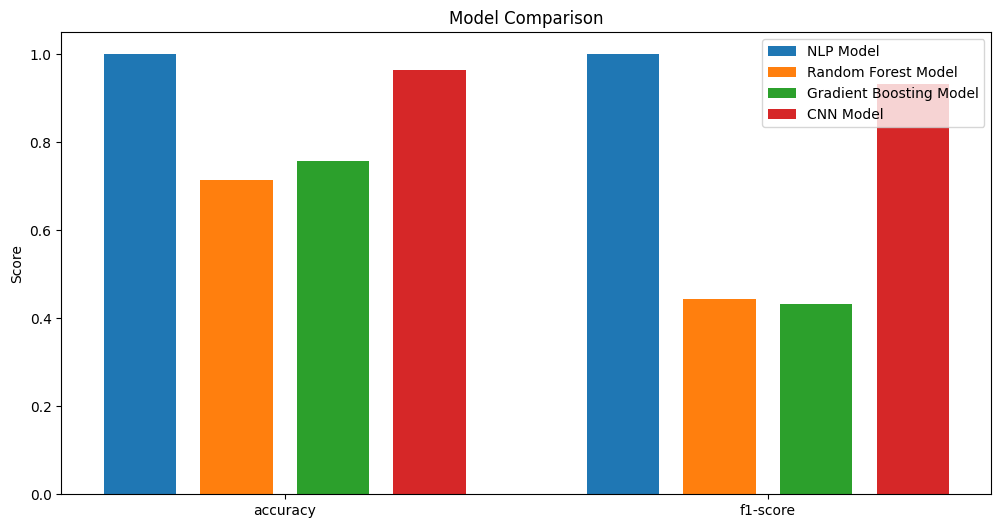

In [45]:
import matplotlib.pyplot as plt

# Visualization
metrics = ['accuracy', 'f1-score']
nlp_scores = [ner_model_metrics[metric] for metric in metrics]
rf_scores = [ml_model_metrics[metric] for metric in metrics]
gb_scores = [gb_model_metrics[metric] for metric in metrics]
cnn_scores = [cnn_model_metrics[metric] for metric in metrics]

x = range(len(metrics))
plt.figure(figsize=(12, 6))
plt.bar(x, nlp_scores, width=0.15, label='NLP Model', align='center')
plt.bar([i + 0.2 for i in x], rf_scores, width=0.15, label='Random Forest Model', align='center')
plt.bar([i + 0.4 for i in x], gb_scores, width=0.15, label='Gradient Boosting Model', align='center')
plt.bar([i + 0.6 for i in x], cnn_scores, width=0.15, label='CNN Model', align='center')
plt.xticks([i + 0.3 for i in x], metrics)
plt.ylabel('Score')
plt.title('Model Comparison')
plt.legend()
plt.show()


# Explanation of Models and Their Contributions

1. **NLP-based Model using Named Entity Recognition (NER):**

This model identifies and classifies entities within the text. It helps extract key entities like countries, indicators, and units from the seriesDescription field.
* **Strength:** Good at identifying specific entities and their types.
* **Weakness:** Requires labeled data for accurate evaluation.


2. **Random Forest Classifier for Text Classification:**

This supervised learning model uses an ensemble of decision trees to classify text data based on features like text length and specific tokens.
* **Strength:** Robust and less prone to overfitting.
* **Weakness:** May require a large amount of data to perform well.

3. **Gradient Boosting Classifier for Text Classification:**

This supervised learning model builds an ensemble of weak learners to create a strong classifier, focusing on reducing errors from previous models.
* **Strength:** Highly accurate and effective for structured data.
* **Weakness:** Computationally intensive and can be sensitive to overfitting.

4. **CNN-based Model for Text Classification:**

This deep learning model uses convolutional layers to capture patterns in the text data. It is trained to classify text based on features extracted from the seriesDescription.
* **Strength:** Effective in capturing local dependencies and patterns in the text.
* **Weakness:** Requires significant computational resources and a large amount of training data.

# Visualize Knowledge Graphs:

In [46]:
import plotly.graph_objects as go
import networkx as nx

def construct_and_visualize_graph(model_type, data_entries):
    nodes = set()
    relationships = []

    if model_type == 'NER':
        entities = extract_entities(data_entries)
        for entity in entities:
            nodes.add(entity[0])
        for i in range(0, len(entities), 2):
            if i + 1 < len(entities):
                relationships.append((entities[i][0], 'RELATED_TO', entities[i + 1][0]))

    elif model_type == 'RandomForest':
        X, y = preprocess_ml_data(data_entries)
        model = RandomForestClassifier()
        model.fit(X, y)
        for i, entry in enumerate(data_entries):
            nodes.add(entry['geoAreaName'])
            nodes.add(entry['indicator'][0])
            relationships.append((entry['geoAreaName'], 'HAS_INDICATOR', entry['indicator'][0]))

    elif model_type == 'GradientBoosting':
        X, y = preprocess_ml_data(data_entries)
        model = GradientBoostingClassifier()
        model.fit(X, y)
        for i, entry in enumerate(data_entries):
            nodes.add(entry['geoAreaName'])
            nodes.add(entry['indicator'][0])
            relationships.append((entry['geoAreaName'], 'HAS_INDICATOR', entry['indicator'][0]))

    elif model_type == 'CNN':
        train_texts, train_labels = preprocess_cnn_data(data_entries)
        train_sequences, tokenizer = tokenize_and_pad(train_texts)
        model = create_cnn_model()
        model.fit(train_sequences, np.array(train_labels), epochs=5, batch_size=32, verbose=2)
        for i, entry in enumerate(data_entries):
            nodes.add(entry['geoAreaName'])
            nodes.add(entry['indicator'][0])
            relationships.append((entry['geoAreaName'], 'HAS_INDICATOR', entry['indicator'][0]))

    G = nx.Graph()
    for node in nodes:
        G.add_node(node)
    for relationship in relationships:
        G.add_edge(relationship[0], relationship[2], label=relationship[1])

    pos = nx.spring_layout(G, k=0.5)
    edge_x = []
    edge_y = []
    for edge in G.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_x.append(x0)
        edge_x.append(x1)
        edge_x.append(None)
        edge_y.append(y0)
        edge_y.append(y1)
        edge_y.append(None)

    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=0.5, color='#888'),
        hoverinfo='none',
        mode='lines')

    node_x = []
    node_y = []
    node_text = []
    for node in G.nodes():
        x, y = pos[node]
        node_x.append(x)
        node_y.append(y)
        node_text.append(node)

    node_trace = go.Scatter(
        x=node_x, y=node_y,
        mode='markers+text',
        hoverinfo='text',
        marker=dict(
            showscale=True,
            colorscale='YlGnBu',
            size=10,
            colorbar=dict(
                thickness=15,
                title='Node Connections',
                xanchor='left',
                titleside='right'
            ),
            line_width=2),
        text=node_text,
        textposition="bottom center")

    fig = go.Figure(data=[edge_trace, node_trace],
                    layout=go.Layout(
                        title=f'Knowledge Graph Visualization ({model_type} Model)',
                        titlefont_size=16,
                        showlegend=False,
                        hovermode='closest',
                        margin=dict(b=20, l=5, r=5, t=40),
                        annotations=[dict(
                            text="Python code by Plotly",
                            showarrow=False,
                            xref="paper", yref="paper",
                            x=0.005, y=-0.002)],
                        xaxis=dict(showgrid=False, zeroline=False),
                        yaxis=dict(showgrid=False, zeroline=False))
                    )
    fig.show()

# Example usage
construct_and_visualize_graph('NER', data_entries)
# construct_and_visualize_graph('RandomForest', data_entries)
# construct_and_visualize_graph('GradientBoosting', data_entries)
# construct_and_visualize_graph('CNN', data_entries)
